In [1]:
import mne
import matplotlib

In [2]:
# Import the BrainVision data into an MNE Raw object
raw = mne.io.read_raw_brainvision('/Users/anuszka/Programming/erpinator-data/OneDrive_1_06-11-2020/GNG_AA0303--Seg Response 5.vhdr')

# Read in the event information as MNE annotations
annot = mne.read_annotations('/Users/anuszka/Programming/erpinator-data/OneDrive_1_06-11-2020/GNG_AA0303--Seg Response 5.vmrk')

# Add the annotations to our raw object so we can use them with the data
raw.set_annotations(annot)


Extracting parameters from /Users/anuszka/Programming/erpinator-data/OneDrive_1_06-11-2020/GNG_AA0303--Seg Response 5.vhdr...
Setting channel info structure...
Finding 'sfreq' from header file: /Users/anuszka/Programming/erpinator-data/OneDrive_1_06-11-2020/GNG_AA0303--Seg Response 5.vhdr


<RawBrainVision | GNG_AA0303--Seg Response 5.dat, 3 x 54595 (213.3 s), ~13 kB, data not loaded>

raw data structure:

```
raw =  { 'channel':
            {'eeg_data': {segments},
             'sth': {nvm}
            }
        }
```

In [72]:
# Map with response markers only
event_dict = {
    'Stimulus/RE*ex*1_n*1_c_1*R*FB': 10004,
    'Stimulus/RE*ex*1_n*1_c_1*R*FG': 10005,
    'Stimulus/RE*ex*1_n*1_c_2*R': 10006,
    'Stimulus/RE*ex*1_n*2_c_1*R': 10007,
    'Stimulus/RE*ex*2_n*1_c_1*R': 10008,
    'Stimulus/RE*ex*2_n*2_c_1*R*FB': 10009,
    'Stimulus/RE*ex*2_n*2_c_1*R*FG': 10010,
    'Stimulus/RE*ex*2_n*2_c_2*R': 10011,
}

merged_event_dict = {
    'correct_response': 0,
    'error_response': 1
}

# Start and end of the segment
tmin, tmax = -0.1, 0.6

# Reconstruct the original events from Raw object
events, event_ids = mne.events_from_annotations(raw, event_id=event_dict)

merged_events = mne.merge_events(events, [10004, 10005, 10009, 10010], merged_event_dict['correct_response'], replace_events=True)
merged_events = mne.merge_events(merged_events, [10006, 10007, 10008, 10011], merged_event_dict['error_response'], replace_events=True)

# Read epochs
epochs = mne.Epochs(raw = raw, 
                    events = merged_events, 
                    event_id = merged_event_dict, 
                    tmin = tmin, 
                    tmax = tmax,
                    baseline=None,
                    preload=True)

Used Annotations descriptions: ['Stimulus/RE*ex*1_n*1_c_1*R*FB', 'Stimulus/RE*ex*1_n*1_c_1*R*FG', 'Stimulus/RE*ex*1_n*1_c_2*R', 'Stimulus/RE*ex*1_n*2_c_1*R', 'Stimulus/RE*ex*2_n*1_c_1*R', 'Stimulus/RE*ex*2_n*2_c_1*R*FB', 'Stimulus/RE*ex*2_n*2_c_1*R*FG', 'Stimulus/RE*ex*2_n*2_c_2*R']
Not setting metadata
Not setting metadata
305 matching events found
No baseline correction applied
0 projection items activated
Loading data for 305 events and 181 original time points ...
1 bad epochs dropped


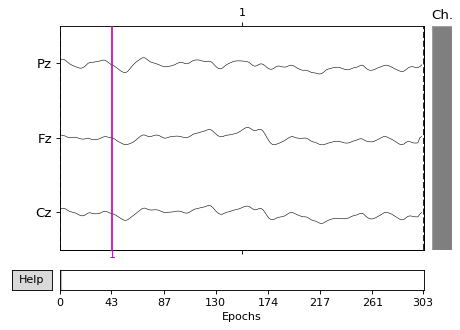

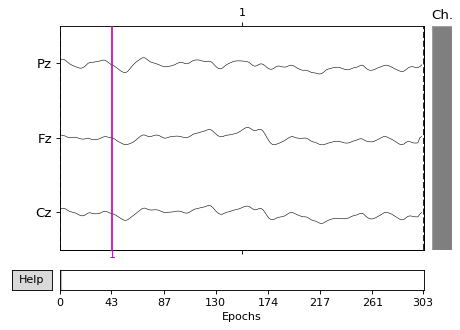

In [87]:
epochs.plot(n_epochs=1, 
            events=merged_events, 
            event_id=merged_event_dict,
            event_colors={0: 'g', 1: 'm'})

## Playground

### Uwagi - małe przemyślenia

- wydaje mi się, że do wygodnego korzystania playground musi pokazywać wszystkie kanały (ew. z opcją wyłączania)
- pogrubiona linia ze średnią jest hardkodowana i trzeba ja zmieniac za każdym razem - i jest to średnia z konkretnego kanału (jednego), podczas gdy widget *Scalp* pozwala na wybranie kilku kanałów i pojedyncze ERP są już uśredniane wzg. kilku kanałów - troche to chyba nie ma sensu, taki misz-masz
- fajniej by chyba było gdyby na wykresie były wyświetlane wszystkie kanały,i na każdy kanał wyświetlana by była średnia z tego kanału jako 'pogrubione' odniesienie i zwykły ERP, plus ew jakies inne uśrednienia

In [88]:
import mne
import numpy as np
import plotly.graph_objects as go
# import tensorflow as tf
from ipywidgets import Dropdown, FloatRangeSlider, IntSlider, interact
from mne.datasets import sample
from scipy import signal
from scipy.interpolate import interp1d

np.set_printoptions(precision=2, linewidth=150)
base_layout = dict(
    template='plotly_dark',
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    margin=dict(l=20, r=20, t=20, b=20),
    dragmode='select',
    showlegend=False,
    width=900,
    height=400,
)

In [89]:
sampling_freq = 1 / (epochs.times[1] - epochs.times[0])

In [91]:
channel_locations = np.array([ch['loc'][:3] for ch in raw.info['chs']])
x, y, z = channel_locations.T

scalp3d = go.FigureWidget(layout=base_layout)
scalp3d.update_layout(width=300, height=300)
scalp3d.add_scatter3d(x=x, y=y, z=z,
                      mode='markers+text',
                      text=list(range(len(x))),
                      marker_size=4,
                      hoverinfo='skip')
# scalp3d.add_scatter3d(x=x, y=y, z=z, mode='markers')

FigureWidget({
    'data': [{'hoverinfo': 'skip',
              'marker': {'size': 4},
              'mode': '…

In [92]:
scalp = go.FigureWidget(layout=base_layout)
scalp.update_layout(width=300, height=300)
scalp.add_scatter(x=x,
                  y=y,
                  mode='text',
                  hoverinfo='skip',
                  text=list(range(len(x))))
# select some points by dragging on the plot

FigureWidget({
    'data': [{'hoverinfo': 'skip',
              'mode': 'text',
              'text': [0, 1, 2…

In [93]:
scalp.data[0].selectedpoints

(0,)

In [94]:
def dist(f1, f2):
    assert f1.shape == f2.shape
    diff = f1 - f2
    return np.dot(diff, diff) ** (1/2) * 1e6
    # return np.dot(diff, diff) * 1e12


def mask(array, window):
    mapping = interp1d([tmin, tmax], [0, len(array)])
    min_index, max_index = mapping(window)
    return np.array([el if min_index < i < max_index
                    else 0
                    for i, el in enumerate(array)])


def band_pass(array, freq_range):
    sos = signal.butter(
        6,
        freq_range,
        'bandpass',
        fs=sampling_freq,
        output='sos'
    )
    return signal.sosfiltfilt(sos, array)


def extract_erp(epoch, selected_chs, band_pass_range, window):
    filtered = epoch[selected_chs].mean(axis=0)
    filtered = band_pass(filtered, band_pass_range)
    filtered = mask(filtered, window)
    return filtered

In [95]:
channel_num = 1
max_amp = 0.000008

# weights = np.ones((1, 60)) / 60
# dist(clean, weights @ epoch0)

conditions = list(epochs.event_id.keys())
max_cond_count = max(epochs[cond].events.__len__()
                     for cond in conditions)

fig = go.FigureWidget(layout=base_layout)
fig.update_layout(
    xaxis_range=[tmin, tmax],
    yaxis_range=[-max_amp, max_amp],
)
fig.add_scatter(
    x=epochs.times,
    hoverinfo='skip',
    mode='lines+markers',
    marker_opacity=0,
    line_color='red',
    line_width=4
)
for _ in range(max_cond_count):
    fig.add_scatter(x=epochs.times,
                    hoverinfo='skip',
                    line_width=1,
                    opacity=0)
window = FloatRangeSlider(value=[tmin, tmax],
                          min=tmin,
                          max=tmax)

# setting window by dragging:
# def set_range(trace, points, selector):
#     window.value = selector.xrange
# fig.data[0].on_selection(set_range)

cond_selector = Dropdown(options=conditions)

@interact(condition=cond_selector)
def set_condition(condition):
    with fig.batch_update():
        all_epochs = epochs[condition]._data
        grand_average = all_epochs.mean(axis=0)[channel_num]
        for trace in fig.data[1:]:
            trace.opacity = 0
        fig.data[0].y = grand_average

# TODO max_cond_count should be changed accoring to the condition used
# ensure, set_condition is executed first, when changing condition
@interact(
    epoch_num=IntSlider(value=1, min=0, max=max_cond_count - 1),
    band_pass_range=FloatRangeSlider(value=[0.1, 20], min=0.1, max=50),
    window=window,
    condition=cond_selector,
    many_epochs=False)
def update_plots(epoch_num, band_pass_range, window, condition, many_epochs):
    with fig.batch_update():
        selected_chs = list(scalp.data[0].selectedpoints)
        all_epochs = epochs[condition]._data
        # dist_total = 0
        for i, epoch in enumerate(all_epochs):
            i += 1     # i=0 is grand_average
            if (i <= epoch_num and many_epochs or
                    i == epoch_num and not many_epochs):
                filtered = extract_erp(epoch,
                                       selected_chs,
                                       band_pass_range,
                                       window)
                fig.data[i].y = filtered
                fig.data[i].opacity = 1 / (epoch_num ** (1/3))
                # dist_total += dist(grand_average, filtered)
            else:
                fig.data[i].opacity = 0
        # print(f' distance: {dist_total:9.0f}')


fig

interactive(children=(Dropdown(description='condition', options=('correct_response', 'error_response'), value=…

interactive(children=(IntSlider(value=1, description='epoch_num', max=220), FloatRangeSlider(value=(0.1, 20.0)…

FigureWidget({
    'data': [{'hoverinfo': 'skip',
              'line': {'color': 'red', 'width': 4},
        …